In [1]:
import pandas as pd
import numpy as np

In [2]:
from litscore.grade import DataGrader, grade_wcpm
from litscore.train import ModelTrainer
from litscore.config import SEED

## 1. Open Data

In [3]:
df = pd.read_csv("./data/larger_wcpm.csv")

## 2. Predict grades based on already trained models

## 3. Train a model

Instanciate ModelTrainer and preprocess the data. You have to choose several parameters that are all listed here. You have to choose between Random Forest ('RF'), XGBoost('XGB') and K nearest neighbors ('KNN'). You will be able to change it after without re processing the data using the set_new_model(model_type, params) method.

In [5]:
config = {
    'model_type': 'XGB',
    'remove_outliers': True,
    'outliers_tol': .15,
    'test_set_size': .2,
    'seed': SEED
}
trainer = ModelTrainer(df,
                       model_type = config['model_type']
                      )
trainer.prepare_train_test_set(remove_outliers = config['remove_outliers'],
                               outliers_tol = config['outliers_tol'],
                               test_set_size = config['test_set_size'],
                               inplace = True
                              )

2020-10-07 18:34:51,957 root         INFO     Removed 166 outliers, 2876 datapoints remaining for training/testing


Take a look at the features used to estimate the wcpm (after standard scaling), plus label 'human_wc':

In [6]:
trainer.features.describe()

,correct_words_pm,added_words_pm,removed_words_pm,replaced_words_pm,asr_word_count_pm,prompt_avg_word_length,prompt_std_word_length,asr_avg_word_length,asr_std_word_length,human_wcpm
count,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,107.682377,9.626946,11.225832,3.795793,117.619406,4.217915,1.969704,4.129150,1.882962,109.109875
std,36.296089,6.614929,24.599078,3.765989,36.515448,0.513844,0.369361,0.536421,0.359985,37.148994
min,0.000000,0.000000,0.000000,0.000000,0.803732,2.357000,0.667000,2.000000,0.000000,0.000000
25%,85.000000,5.000000,2.000000,1.000000,95.582619,4.040000,1.855000,3.914750,1.691750,86.000000
50%,112.000000,8.302016,4.553308,3.000000,122.000000,4.258000,1.993000,4.179000,1.935000,113.000000
75%,133.000000,13.000000,10.000000,5.000000,142.000000,4.523000,2.229000,4.440000,2.114250,134.250000
max,219.591194,78.000000,284.654213,41.000000,253.000000,5.207000,2.757000,5.429000,2.985000,259.000000


#### Now, let's train the model and evaluate it's performances on the test set

In [ ]:
trainer.train()

In [ ]:
_, summary, errors = trainer.evaluate_model()
print(summary)
print(errors)

#### Now we want to train another model, but without having to redo the preprocesssing: we can use self.set_new_model() and specify both the model type and the params for the model. 

2020-10-07 19:57:46,210 root         INFO     Training KNN


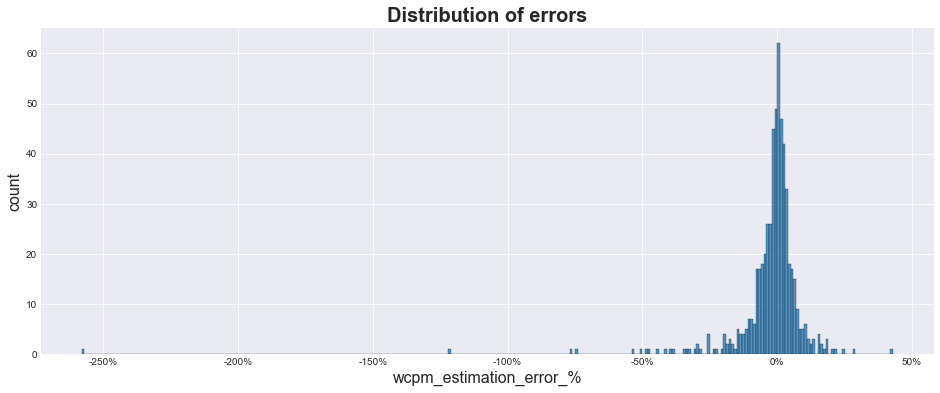

In [156]:
# model_type = 'XGB'
# params = {'n_estimators': 200,
#           'learning_rate': 0.04,
#           'max_depth': 5,
#           'subsample': 0.8,
# #           'colsample_bytree': 0.9,
#           'gamma': 0
#          }

# model_type = 'KNN'
# params = {'n_neighbors': 4,
#           'weights': 'distance'
#          }

model_type = 'RF'
params = {'max_features': 6,
          'n_estimators': 200,
          'max_depth': 20,
          'min_samples_split': 8,
          'min_samples_leaf': 2,
          'bootstrap': True
         }

trainer.set_new_model(model_type = model_type,
                      params = params
                     )
trainer.train()
# trainer.feature_importance(threshold = 0)
stats, summary, errors = trainer.evaluate_model(visualize = True)

In [157]:
summary

wcpm_estimation_error        wcpm_estimation_abs_error         \
                          mean    std                      mean    std   
wcpm_bin                                                                 
150+                      7.29  15.22                      8.25  14.71   
75-150                   -0.24   5.96                      4.15   4.28   
<75                      -4.45   8.04                      6.99   5.95   
total                    -0.15   8.49                      5.12   6.76   

         wcpm_estimation_error_%        wcpm_estimation_abs_error_%         
                            mean    std                        mean    std  
wcpm_bin                                                                    
150+                        3.91   6.60                        4.49   6.21  
75-150                     -0.52   5.89                        3.92   4.42  
<75                       -13.68  32.26                       18.42  29.79  
total                      -2.40  15.68                        6.60  14.42

In [158]:
errors

Total Count          Error > 1%          Error > 5%           \
               count % of bin      count % of bin      count % of bin   
wcpm_bin                                                                
150+            65.0    100.0       51.0     78.5       17.0     26.2   
75-150         407.0    100.0      317.0     77.9      116.0     28.5   
<75            104.0    100.0       98.0     94.2       75.0     72.1   
total          576.0    100.0      466.0     80.9      208.0     36.1   

         Error > 10%           
               count % of bin  
wcpm_bin                       
150+             6.0      9.2  
75-150          25.0      6.1  
<75             61.0     58.7  
total           92.0     16.0

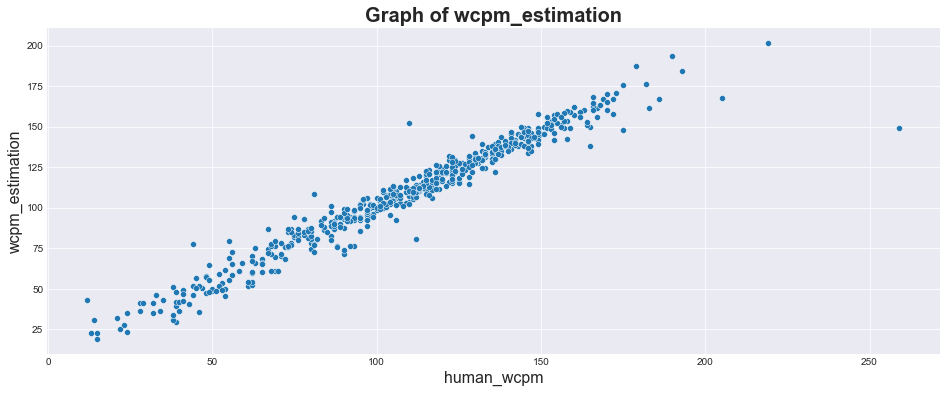

In [159]:
trainer.plot_wcpm_scatter(stats, y = 'wcpm_estimation', x = 'human_wcpm')

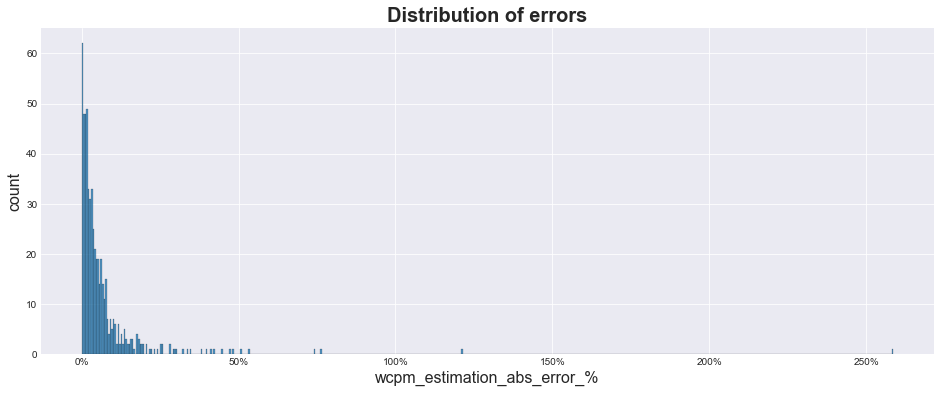

In [160]:
trainer.plot_wcpm_distribution(stats, x='wcpm_estimation_abs_error_%', binwidth=.005)

## 4. Grid search

In [217]:
# RandomForestRegressor
model_type = 'RF'
cv_params={
#     'max_features': np.arange(1, 9, 1),
    'max_features': [6],
#     'n_estimators': list(np.arange(100, 2001, 100)),
    'n_estimators': [600],
#     'max_depth': np.arange(5, 120, 5),
#     'max_depth': np.arange(1, 20, 1)
    'max_depth': [10],
#     'min_samples_split': np.arange(1, 15, 1),
    'min_samples_split': [4],
#     'min_samples_leaf': np.arange(1, 6, 1)
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# XGBoostRegressors
# model_type = 'XGB'
# cv_params = {
# #     'n_estimators': list(np.arange(10, 100, 10)) + list(np.arange(100, 2001, 100)),
# #     'n_estimators': [200, 300, 400, 500, 600, 700, 1000],
#     'n_estimators': [200],
# #     'learning_rate': np.arange(0.0, 0.101, 0.005),
# #     'learning_rate': [0.01, 0.02, 0.04, 0.05, 0.1],
#     'learning_rate': [0.04],
# #     'max_depth': np.arange(3, 26, 1)
#     'max_depth': [5],
# #     'subsample': np.arange(0.6, 1, 0.01),
#     'subsample': [0.8],
# #     'colsample_bytree': np.arange(0.3, 1, 0.02),
# #     'colsample_bytree': [0.9],
# #     'gamma': [0, 1, 5]
#     'gamma': [0]
# }

# KNN
# model_type = 'KNN'
# cv_params = {
#     "n_neighbors": np.arange(1, 30, 1),
#     'weights': ['uniform', 'distance']
# }

In [218]:
gd = trainer.grid_search(model_type = model_type,
                         cv_params=cv_params,
                         cv_folds=5,
                         scoring_metric = 'r2',
                         verbose = 5
                        )


------------------------------------------------------ Estimator: ------------------------------------------------------
RandomForestRegressor

------------------------------------------------ Metric for evaluation: ------------------------------------------------
r2

---------------------------------------------------- Fixed params: -----------------------------------------------------
max_features 6
n_estimators 600
max_depth 10
min_samples_split 4
min_samples_leaf 1
bootstrap True

------------------------------------------------- Params to be tested: -------------------------------------------------

 # of possible combinations to be cross-validated: 1

Continue with these c-v parameters ? (y/n)  y
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.2s finished


{}


ValueError: Could not interpret value `param_n_estimators` for parameter `x`

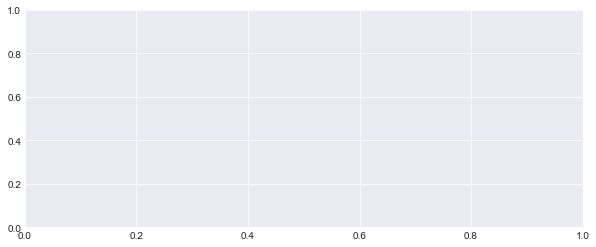

In [219]:
print(gd.best_params_)
trainer.plot_grid_search(gd.cv_results_, x='n_estimators', hue=None, log_scale = False)

In [220]:
stats, summary, errors = trainer.evaluate_model(visualize = False)

In [221]:
summary

wcpm_estimation_error       wcpm_estimation_abs_error        \
                          mean   std                      mean   std   
wcpm_bin                                                               
150+                      2.83  9.19                      4.63  8.42   
75-150                   -0.03  2.78                      1.99  1.95   
<75                      -0.19  4.31                      2.65  3.40   
total                     0.26  4.37                      2.40  3.65   

         wcpm_estimation_error_%        wcpm_estimation_abs_error_%         
                            mean    std                        mean    std  
wcpm_bin                                                                    
150+                        1.42   4.35                        2.54   3.79  
75-150                     -0.10   2.53                        1.80   1.78  
<75                        -1.64  13.11                        6.79  11.32  
total                      -0.20   6.17                        2.78   5.51

In [222]:
errors

Total Count          Error > 1%          Error > 5%           \
               count % of bin      count % of bin      count % of bin   
wcpm_bin                                                                
150+            65.0    100.0       34.0     52.3        9.0     13.8   
75-150         407.0    100.0      245.0     60.2       22.0      5.4   
<75            104.0    100.0       90.0     86.5       37.0     35.6   
total          576.0    100.0      369.0     64.1       68.0     11.8   

         Error > 10%           
               count % of bin  
wcpm_bin                       
150+             3.0      4.6  
75-150           2.0      0.5  
<75             18.0     17.3  
total           23.0      4.0

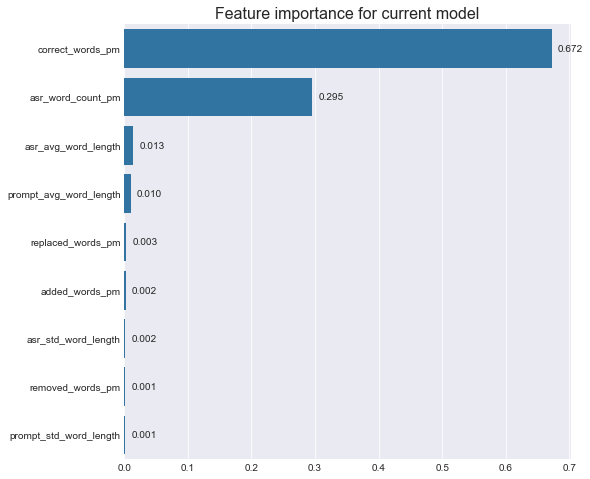

In [223]:
trainer.feature_importance()

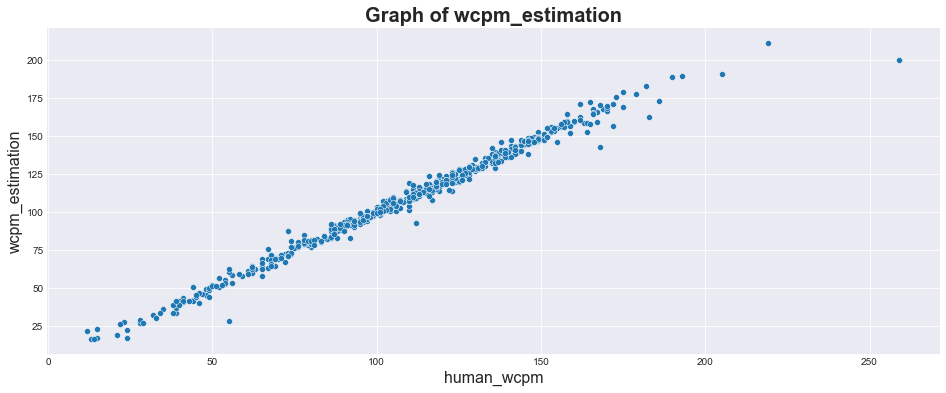

In [224]:
trainer.plot_wcpm_scatter(stats, y = 'wcpm_estimation', x = 'human_wcpm')

In [210]:
trainer.save_model(scaler = True, model = True, replace = True)

2020-10-07 22:19:30,505 root         INFO     Saved file standard_scaler.joblib in dir ./litscore/models/
2020-10-07 22:19:31,422 root         INFO     Saved file RF.joblib in dir ./litscore/models/
